In [1]:
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)

import sys
sys.path.insert(0,"/home/ad/alberta/git/xscale")
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

from dask_jobqueue import PBSCluster
from dask.distributed import Client
import dask.dataframe as dd
import dask

import zarr
import os
import glob
import numpy as np

%matplotlib inline


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
cluster = PBSCluster(
    cores=1,
    memory="120GB",
    project='pangeo',
    processes=1,
    walltime='04:00:00',
    local_directory='$TMPDIR')
cluster

In [3]:
cluster.scale(10)

In [4]:
client = Client(cluster) # scheduler_file="/home/ad/briolf/scheduler.json")
client

Client Scheduler: tcp://10.120.40.165:45875 Dashboard: http://10.120.40.165:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
print(len(client.scheduler_info()["workers"]))

0


In [6]:
%%time
root = "/work/ALT/odatis/eNATL60/BLBT02/gridT-2D/"
files = sorted(glob.glob(root+'/*.nc'))

drop_vars = [
    'nav_lat',
    'nav_lon',
    'somxl010',
    'sosaline',
    'sosstsst']


open_kwargs = dict(drop_variables=(drop_vars),decode_cf=True, concat_dim="time_counter") #, combine='nested')
dsall = xr.open_mfdataset(files, combine='nested',parallel=True, **open_kwargs)
dsall

CPU times: user 3.1 s, sys: 232 ms, total: 3.33 s
Wall time: 11.2 s


<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(11688,), chunksize=(24,)>
  * time_counter          (time_counter) datetime64[ns] 2009-06-30T00:30:00 ... 2010-10-29T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(24, 2)>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(24, 2)>
    sossheig              (time_counter, y, x) float32 dask.array<shape=(11688, 4729, 8354), chunksize=(24, 4729, 8354)>
Attributes:
    name:         /scratch/tmp/3746956/eNATL60-BLBT02_1h_20090630_20090704_gr...
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2018-Dec-31 17:48:48 GMT
    uuid:         bd

In [7]:
%%time

dsfilt=xr.open_mfdataset("/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60-BLBT02_tide_y2009m07-y2010m06_time_k*.nc",combine='nested',
                     concat_dim='time_counter',parallel=True,decode_cf=True) 
dsfilt

CPU times: user 33 s, sys: 2.03 s, total: 35 s
Wall time: 34.5 s


<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, time_counter: 8735, x: 8353, y: 4729)
Coordinates:
  * time_counter         (time_counter) datetime64[ns] 2009-06-30T00:30:00 ... 2009-08-10T15:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    tide_time            (time_counter, y, x) float64 dask.array<shape=(8735, 4729, 8353), chunksize=(1, 4729, 8353)>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(8735, 2), chunksize=(1, 2)>
Attributes:
    history:                    Fri Jun 19 13:37:06 2020: ncks -O -d x,0,8352...
    history_of_appended_files:  Thu Jun 18 11:09:26 2020: Appended file time_...
    NCO:                        4.6.6
    nco_openmp_thread_number:   1

In [8]:
ssh_all_GS=dsall.sossheig[0:8735,2000,2000]
ssh_pytide_GS=dsfilt.tide_time[:,2000,2000]
ssh_filt_GS=ssh_all_GS-ssh_pytide_GS
time=dsall.time_counter[0:8735]

In [9]:
ssh_all_GS.load()
ssh_pytide_GS.load()
ssh_filt_GS.load()
time.load()

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.DataArray 'time_counter' (time_counter: 8735)>
array(['2009-06-30T00:30:00.000000000', '2009-06-30T01:30:00.000000000',
       '2009-06-30T02:30:00.000000000', ..., '2010-06-28T20:30:00.000000000',
       '2010-06-28T21:30:00.000000000', '2010-06-28T22:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2009-06-30T00:30:00 ... 2010-06-28T22:30:00
  * time_counter   (time_counter) datetime64[ns] 2009-06-30T00:30:00 ... 2010-06-28T22:30:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1900-01-01 00:00:00
    bounds:         time_counter_bounds

/softs/rh7/conda/4.5.4/envs/pangeo_full_201909/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


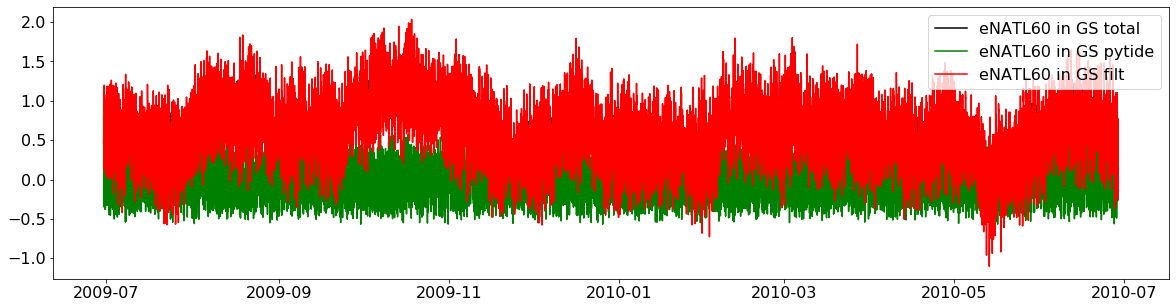

In [10]:
fig=plt.figure(figsize=(20,5))
plt.plot(time,ssh_all_GS,'k',label='eNATL60 in GS total')
plt.plot(time,ssh_pytide_GS,'g',label='eNATL60 in GS pytide')
plt.plot(time,ssh_filt_GS,'r',label='eNATL60 in GS filt')
plt.legend()

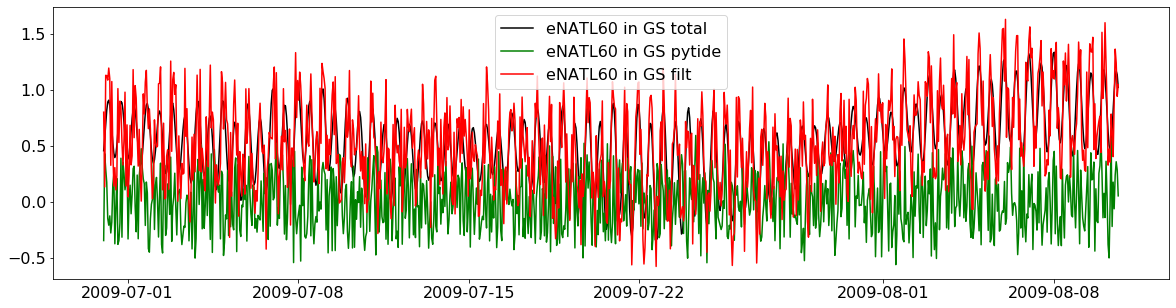

In [11]:
fig=plt.figure(figsize=(20,5))
plt.plot(time[0:1000],ssh_all_GS[0:1000],'k',label='eNATL60 in GS total')
plt.plot(time[0:1000],ssh_pytide_GS[0:1000],'g',label='eNATL60 in GS pytide')
plt.plot(time[0:1000],ssh_filt_GS[0:1000],'r',label='eNATL60 in GS filt')
plt.legend()

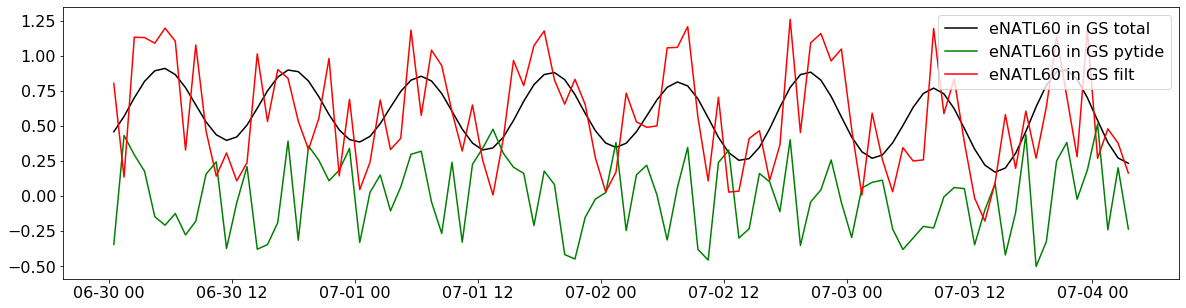

In [12]:
fig=plt.figure(figsize=(20,5))
plt.plot(time[0:100],ssh_all_GS[0:100],'k',label='eNATL60 in GS total')
plt.plot(time[0:100],ssh_pytide_GS[0:100],'g',label='eNATL60 in GS pytide')
plt.plot(time[0:100],ssh_filt_GS[0:100],'r',label='eNATL60 in GS filt')
plt.legend()

In [13]:
NPADDING = 2
SPtime_h = xfft.fft(ssh_all_GS,dim='time_counter', dx=1., detrend='mean',nfft=ssh_all_GS.shape[0]*NPADDING,tapering=True)
MEANPSD_h=xfft.psd(SPtime_h).load()
freqs_h=MEANPSD_h.f_time_counter.values
freqs_h = freqs_h[NPADDING::] 


In [14]:
NPADDING = 2
SPtime_pytide = xfft.fft(ssh_pytide_GS,dim='time_counter', dx=1., detrend='mean',nfft=ssh_pytide_GS.shape[0]*NPADDING,tapering=True)
MEANPSD_pytide=xfft.psd(SPtime_pytide).load()
freqs_pytide=MEANPSD_pytide.f_time_counter.values
freqs_pytide = freqs_pytide[NPADDING::] 


In [15]:
NPADDING = 2
SPtime_hp = xfft.fft(ssh_filt_GS,dim='time_counter', dx=1., detrend='mean',nfft=ssh_filt_GS.shape[0]*NPADDING,tapering=True)
MEANPSD_hp=xfft.psd(SPtime_hp).load()
freqs_hp=MEANPSD_hp.f_time_counter.values
freqs_hp = freqs_hp[NPADDING::] 


Text(0.5, 1.0, 'Temporal Spectrum of eNATL60 SSH in GS')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


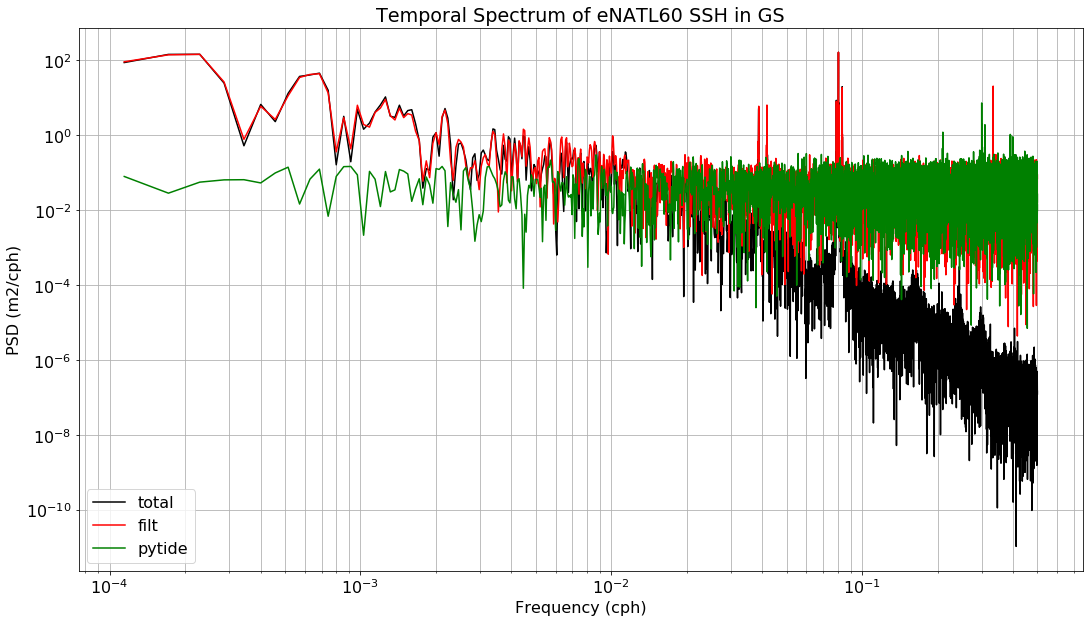

In [16]:
import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_h,MEANPSD_h[NPADDING::],'k',label='total')
ax.loglog(freqs_hp,MEANPSD_hp[NPADDING::],'r',label='filt')
ax.loglog(freqs_pytide,MEANPSD_pytide[NPADDING::],'g',label='pytide')
#ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cph)')
plt.ylabel('PSD (m2/cph)')
plt.legend()
plt.title('Temporal Spectrum of eNATL60 SSH in GS')

Text(0.5, 1.0, 'Temporal Spectrum of eNATL60 SSH in GS')

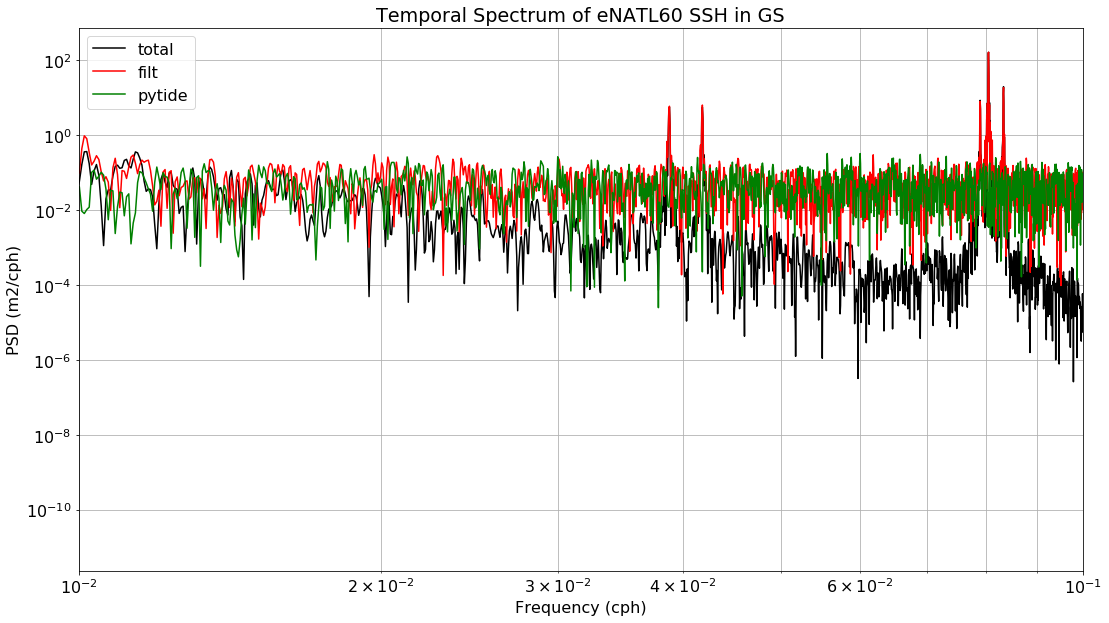

In [17]:
import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_h,MEANPSD_h[NPADDING::],'k',label='total')
ax.loglog(freqs_hp,MEANPSD_hp[NPADDING::],'r',label='filt')
ax.loglog(freqs_pytide,MEANPSD_pytide[NPADDING::],'g',label='pytide')
ax.set_xlim(1e-2,1e-1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cph)')
plt.ylabel('PSD (m2/cph)')
plt.legend()
plt.title('Temporal Spectrum of eNATL60 SSH in GS')